In [4]:
def get_df(indexes):
    return pd.DataFrame([0 for x in range(len(indexes))], indexes)

def get_actions(batch):
    return batch.groupby(["recommender_name"]).count()["success"]

def update(indexes, batch, collector):
    actions = get_actions(batch)
    for arm in indexes:
        if arm in batch["recommender_name"].unique():
            collector.loc[arm] += actions.loc[arm]
    return collector

def reset(indexes, batch, collector, df, num_batch, period):
    actions = get_actions(batch)
    for arm in indexes:
        if arm in batch["recommender_name"].unique():
            collector.loc[arm] = actions.loc[arm]
    if df.shape[1] < period:
        df[str(num_batch)] = collector
    else:
        del df[df.columns[0]]
        df[str(num_batch)] = collector
    return df.sum(axis = 1)


In [5]:
class CTR():
    def __init__(self, data, indexes, period):
        self.data = data
        self.indexes = indexes
        self.period = period
        self.arms_gains = get_df(self.indexes)
        self.arms_plays = get_df(self.indexes)
        self.arms_ctrs = get_df(self.indexes)
        self.num_batch = 0
        self.all_gains = get_df(self.indexes)
        self.all_plays = get_df(self.indexes)

    def get_CTR_zero(self, batch):
        good_sample = batch[batch.success.apply(lambda s: s == 1)]
        self.arms_gains = update(self.indexes, self.good_sample, self.arms_gains)
        self.arms_plays = update(self.indexes, batch, self.arms_plays)
        self.num_batch += 1
        ctrs = self.arms_gains/self.arms_plays
        ctrs.fillna(0, inplace = True)

        if self.num_batch > self.period:
            self.arms_gains = get_df(self.indexes)
            self.arms_plays = get_df(self.indexes)
            self.num_batch = 0
        return ctrs[0]          
        
    def get_CTR_win(self, batch):
        self.arms_gains = get_df(self.indexes)
        self.arms_plays = get_df(self.indexes)
        self.num_batch += 1
        
        good_sample = batch[batch.success.apply(lambda s: s == 1)]
        self.sum_all_gains = reset(self.indexes, good_sample, self.arms_gains, self.all_gains, self.num_batch, self.period)
        self.sum_all_plays = reset(self.indexes, batch, self.arms_plays, self.all_plays, self.num_batch, self.period)
        
        ctrs = self.sum_all_gains/self.sum_all_plays
        ctrs.fillna(0, inplace = True)
        
        return ctrs
       
def get_scalar(ctr, p_proba):
    ctr_s = pd.DataFrame.from_dict(ctr, orient='index', dtype=None).sort_index()
    p_proba_s = pd.DataFrame.from_dict(p_proba, orient='index', dtype=None).sort_index()
    scalar = ctr_s[0].dot(p_proba_s[0])
    return scalar

In [6]:
#Бандит, обнуляющий результаты испытаний раз в заданный период period
class Bandit():

    def __init__(self, data, indexes, period):
        self.data = data
        self.period = period
        self.indexes = indexes
        self.arms_gains = get_df(self.indexes)
        self.arms_plays =  get_df(self.indexes)
        self.arms_ctr =  get_df(self.indexes)
        self.all_gains = pd.DataFrame([0 for x in range(len(indexes))], indexes, ["0"])
        self.all_plays = pd.DataFrame([0 for x in range(len(indexes))], indexes, ["0"])
        self.num_batch = 0

    def partial_fit(self, batch, step):
        self.step = step
        good_sample = batch[batch.success.apply(lambda s: s == 1)] 
        self.arms_gains = update(indexes, good_sample, self.arms_gains)
        self.arms_plays = update(indexes, batch, self.arms_plays)
        self.num_batch += 1
        if self.num_batch > self.period:
            self.arms_gains = get_df(self.indexes)
            self.arms_plays = get_df(self.indexes)
            self.num_batch = 0
        return self 
          
    def upperBound(self, Num_of_draws):
        if Num_of_draws == 0:
            Num_of_draws = 0.1
        return math.sqrt(2 * math.log(self.step) / Num_of_draws)

    def ucb1_probs(self):
        ctrs = self.arms_gains/self.arms_plays
        ctrs.fillna(0, inplace = True)
        upperbounds = pd.DataFrame([ctrs.iloc[i] + self.upperBound(self.arms_plays.iloc[i][0]) for i in range(len(ctrs))], self.indexes)        
        ub_weights = pd.DataFrame([upperbounds.iloc[i]/upperbounds.sum(axis = 0)[0] if upperbounds.sum(axis = 0)[0] !=0 else 0 for i in range(len(upperbounds))], self.indexes)
        return ub_weights[0]
 
    def predict_proba(self):
         return self.ucb1_probs()
    
    def predict(self):
        return self.predict_proba().idxmax()

In [7]:
#кумулятивный бандит, накапливающий результаты испытаний
class Bandit_cum(Bandit):
    def partial_fit(self, batch, step):
        self.step = step
        good_sample = batch[batch.success.apply(lambda s: s == 1)]
        self.arms_gains = update(indexes, good_sample, self.arms_gains)
        self.arms_plays = update(indexes, batch, self.arms_plays)
        return self

In [8]:
#бандит, накапливающий результаты испытаниq за определенный интервал-скользящее окно (win=window)
class Bandit_win(Bandit):
    
    def partial_fit(self, batch, step):
        self.arms_gains = get_df(self.indexes)
        self.arms_plays = get_df(self.indexes)
        self.num_batch += 1
        self.step = step
        good_sample = batch[batch.success.apply(lambda s: s == 1)]
        self.sum_all_gains = reset(self.indexes, good_sample, self.arms_gains, self.all_gains, self.num_batch, self.period)
        self.sum_all_plays = reset(self.indexes, batch, self.arms_plays, self.all_plays, self.num_batch, self.period)
        return self
    
    def ucb1_probs(self):
        ctrs = self.sum_all_gains/self.sum_all_plays
        ctrs.fillna(0, inplace = True)
        upperbounds = pd.DataFrame([ctrs.iloc[i] + self.upperBound(self.sum_all_plays.iloc[i]) for i in range(len(ctrs))], self.indexes)  
        ub_weights = pd.DataFrame([upperbounds.iloc[i]/upperbounds.sum(axis = 0)[0] if upperbounds.sum(axis = 0)[0] !=0 else 0  for i in range(len(upperbounds))], self.indexes)
        return ub_weights[0]

In [11]:
#trials for bandits
period = 60
period_ctr = 30
b = Bandit_cum(data, indexes, period)
c = CTR(data, indexes, period_ctr)
scalars = []
step = 0
right_answers = 0

for batch_id, next_batch_id in tqdm(zip(batches_id[:-1], batches_id[1:])):
    step += 1
    batch = data[data["1_min_interval"] == batch_id]
    next_batch = data[data["1_min_interval"] == next_batch_id]    
    b.partial_fit(batch, step)
    p_proba = b.predict_proba()
    p = b.predict()
    ctr = c.get_CTR_win(next_batch)
    winner_UB = p
    winner_CTR = ctr.idxmax()
    scalar = ctr.dot(p_proba)
    scalars.append(scalar)
    
    if winner_UB == winner_CTR:
        right_answers += 1
    
    if step > 1000:
        break
    
print(right_answers/(len(batches_id)))
print(sum(scalars)/len(scalars))


1000it [00:55, 17.41it/s]

0.0047867902156251375
0.0258911213029


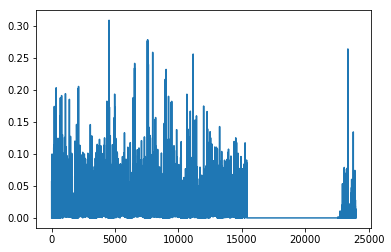

In [20]:
import matplotlib.pyplot as plt

plt.plot(scalars)
plt.show()